======================================================
# **Deep Learning Course** - Fall 2021 -25647
## HW1-Q1
======================================================

======================================================
### **Student Information:**
* MohammadAmin Alamalhoda
* 97102099
* Github  https://github.com/MohammadAminAlamalhoda/sign-language-Detector 
======================================================

** NOTE: my final accuracy on test dataset is 88%. Also, I have augmented the dataset for better performance. 

In [1]:
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
import tensorflow.compat.v1 as tf
from scipy.ndimage.interpolation import rotate
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Mounting the Google Drive for loadring the files (if you are using your local machine, don't run the cell below)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading tensorboard
%load_ext tensorboard

## Loading datas

In [9]:
train_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW01/Q1_train.csv'
test_data_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW01/Q1_test.csv'
data_train = []
data_test = []
with open(train_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_train.append(row)
with open(test_data_dir, 'r') as csvfile:
  csvreader = csv.reader(csvfile)
  for row in csvreader:
      data_test.append(row)

data_train = np.array(data_train[1:], dtype=np.float32)
data_test = np.array(data_test[1:], dtype=np.float32)

In [10]:
num_of_train_samples = len(data_train[:, 1])
validation_set_size = 0.7

x_train = data_train[0:int(validation_set_size*num_of_train_samples), 1:]
y_train_cls = data_train[0:int(validation_set_size*num_of_train_samples), 0]

for i in range(len(y_train_cls)):
  if y_train_cls[i]>=9:
    y_train_cls[i] = y_train_cls[i]-1

x_validation = data_train[int(validation_set_size*num_of_train_samples)+1:, 1:]
y_validation_cls = data_train[int(validation_set_size*num_of_train_samples)+1:, 0]

for i in range(len(y_validation_cls)):
  if y_validation_cls[i]>=9:
    y_validation_cls[i] = y_validation_cls[i]-1


x_test = data_test[:,1:]
y_test_cls = data_test[:,0]

for i in range(len(y_test_cls)):
  if y_test_cls[i]>=9:
    y_test_cls[i] = y_test_cls[i]-1

img_size_flat = len(x_train[0])
img_shape = (int(np.sqrt(img_size_flat)), int(np.sqrt(img_size_flat)))
alphabets =  'ABCDEFGHIKLMNOPQRSTUVWXY'
num_classes = len(alphabets)

# normalization
x_train = x_train/255
x_test = x_test/255
x_validation = x_validation/255

In [11]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test_cls.reshape(-1, 1)).toarray()
y_validation = enc.fit_transform(y_validation_cls.reshape(-1, 1)).toarray()

## Part a - showing some of the the images

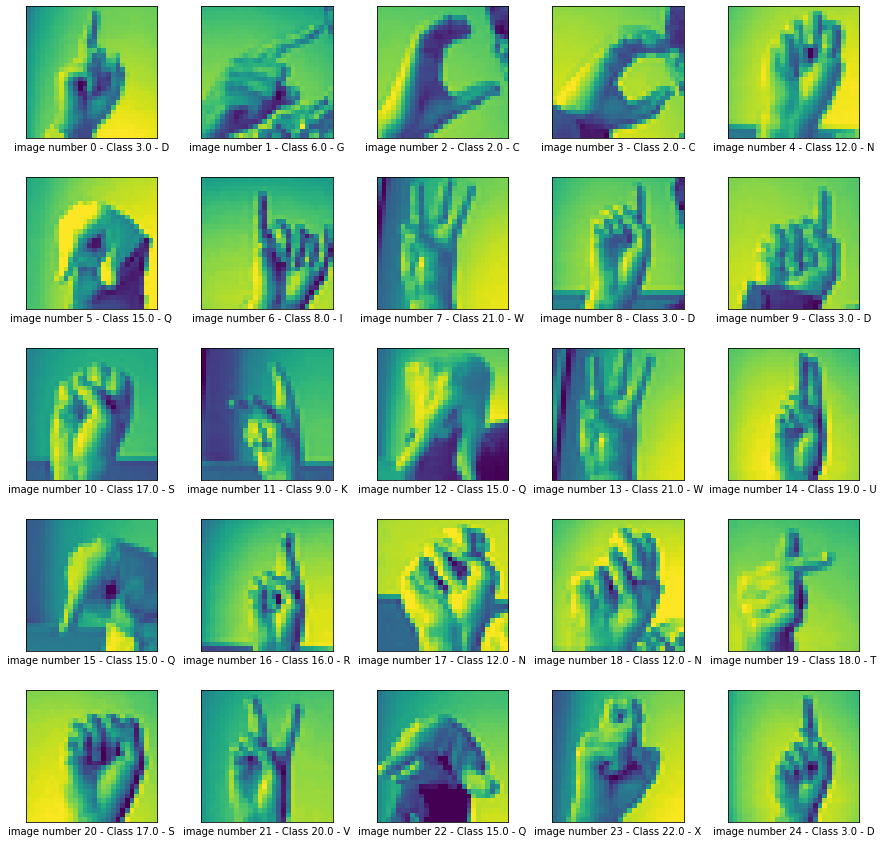

In [28]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    image = x_train[i].reshape(img_shape)
    # Set the label for the sub-plot.
    ax.set_xlabel("image number {0} - Class {1} - {2}".format(i, y_train_cls[i], alphabets[int(y_train_cls[i])]))
    # Plot the image.
    ax.imshow(image)
    # Remove ticks from each sub-plot.
    ax.set_xticks([])
    ax.set_yticks([])

## Part b - Designing an MLP

#### SGD 

##### Network graph

In [67]:
tf.reset_default_graph()

learning_rate = 0.02

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')
# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))


y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

##### Helper Functions

In [7]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, Loss] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, _] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,10)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, Loss] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, _] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

def calcAccuracy(feed_dict):
    acc, loss = session.run([accuracy, cost], feed_dict=feed_dict)
    return acc, loss

def plot_weights(weights):
    w = session.run(weights)
    w_min = -1
    w_max = 1
    fig, axes = plt.subplots(6, 4, figsize=(15,15))
    for i, ax in enumerate(axes.flat):
      image = w[:, i].reshape(img_shape)
      ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
      ax.set_xlabel("Weights: {0}".format(i))
      ax.set_xticks([])
      ax.set_yticks([])
    plt.show()
    

def print_confusion_matrix():
    cls_true = feed_dict_train[y_true_cls]
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_train)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.04 - Loss = 3.2521

 ====== Epoch 1 ====== 
Training Acc = 0.49 - Validation Acc = 0.49 - Test Acc = 0.42 - Loss = 2.3219

 ====== Epoch 11 ====== 
Training Acc = 0.70 - Validation Acc = 0.70 - Test Acc = 0.58 - Loss = 1.5023

 ====== Epoch 21 ====== 
Training Acc = 0.78 - Validation Acc = 0.77 - Test Acc = 0.64 - Loss = 1.3066

 ====== Epoch 31 ====== 
Training Acc = 0.83 - Validation Acc = 0.82 - Test Acc = 0.65 - Loss = 1.2212

 ====== Epoch 41 ====== 
Training Acc = 0.85 - Validation Acc = 0.84 - Test Acc = 0.66 - Loss = 1.1526

 ====== Epoch 51 ====== 
Training Acc = 0.87 - Validation Acc = 0.86 - Test Acc = 0.66 - Loss = 1.1074

 ====== Epoch 61 ====== 
Training Acc = 0.88 - Validation Acc = 0.88 - Test Acc = 0.67 - Loss = 1.0919

 ====== Epoch 71 ====== 
Training Acc = 0.89 - Validation Acc = 0.89 - Test Acc = 0.67 - Loss = 1.0640

 ====== Epoch 81 ====== 
Training Acc = 0.90 - Validation Acc = 0

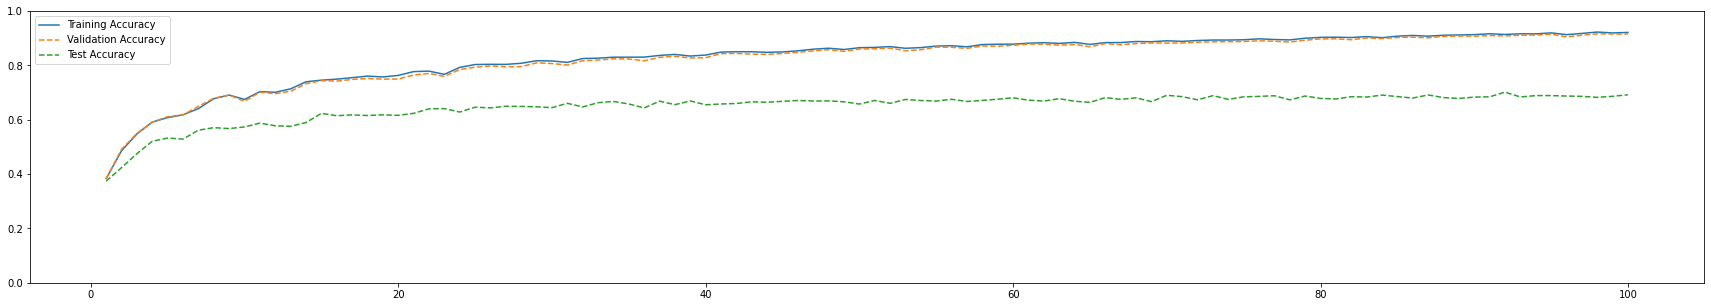

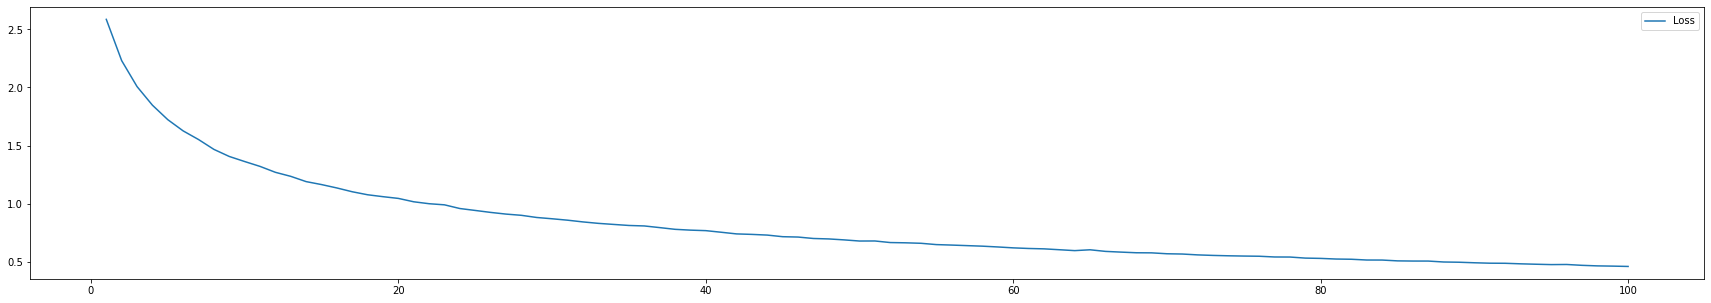

In [69]:
# print_confusion_matrix()
num_epochs = 100
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

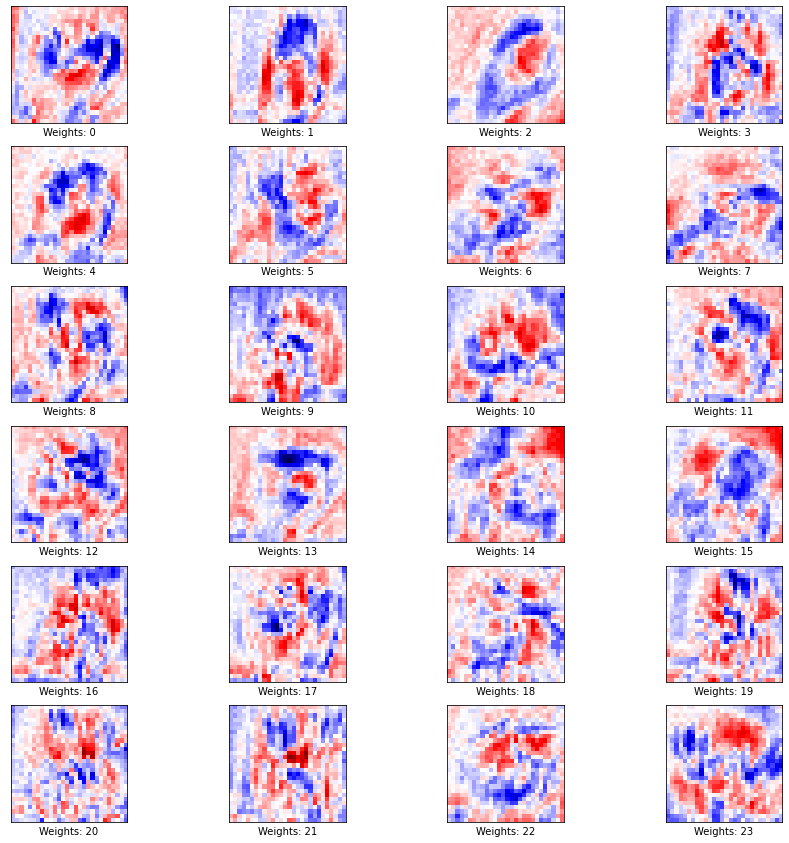

In [70]:
# plotting weights
plot_weights(weights_out)

#### ADAM

##### Network graph

In [71]:
tf.reset_default_graph()

learning_rate = 3e-4
beta1 = 0.85
beta2 = 0.999
# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(y_pred_act, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb]}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.04 - Loss = 3.4219

 ====== Epoch 1 ====== 
Training Acc = 0.44 - Validation Acc = 0.45 - Test Acc = 0.39 - Loss = 2.3646

 ====== Epoch 11 ====== 
Training Acc = 0.71 - Validation Acc = 0.71 - Test Acc = 0.59 - Loss = 1.5011

 ====== Epoch 21 ====== 
Training Acc = 0.79 - Validation Acc = 0.78 - Test Acc = 0.62 - Loss = 1.2884

 ====== Epoch 31 ====== 
Training Acc = 0.84 - Validation Acc = 0.84 - Test Acc = 0.67 - Loss = 1.1619

 ====== Epoch 41 ====== 
Training Acc = 0.87 - Validation Acc = 0.86 - Test Acc = 0.68 - Loss = 1.0899

 ====== Epoch 51 ====== 
Training Acc = 0.89 - Validation Acc = 0.89 - Test Acc = 0.67 - Loss = 1.0582

 ====== Epoch 61 ====== 
Training Acc = 0.90 - Validation Acc = 0.90 - Test Acc = 0.68 - Loss = 1.0370

 ====== Epoch 71 ====== 
Training Acc = 0.92 - Validation Acc = 0.91 - Test Acc = 0.68 - Loss = 1.0364

 ====== Epoch 81 ====== 
Training Acc = 0.93 - Validation Acc = 0

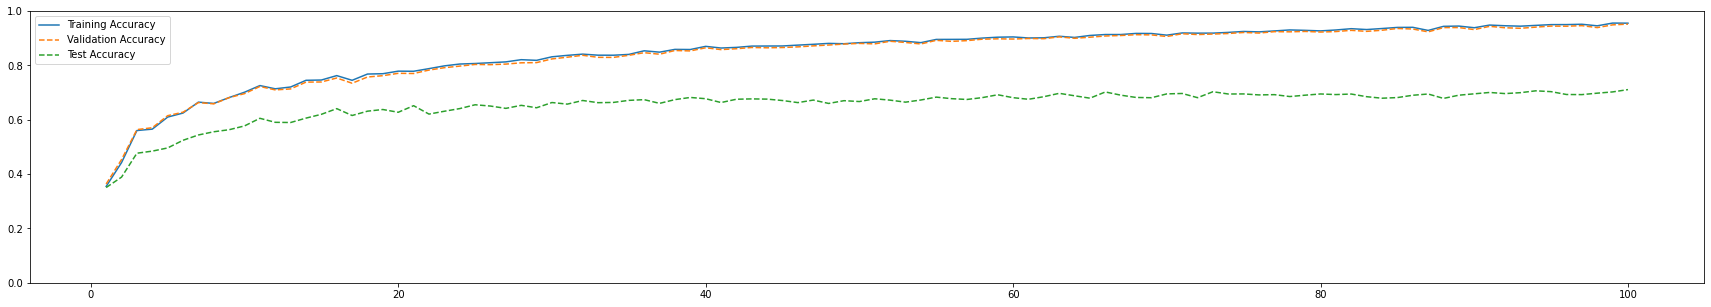

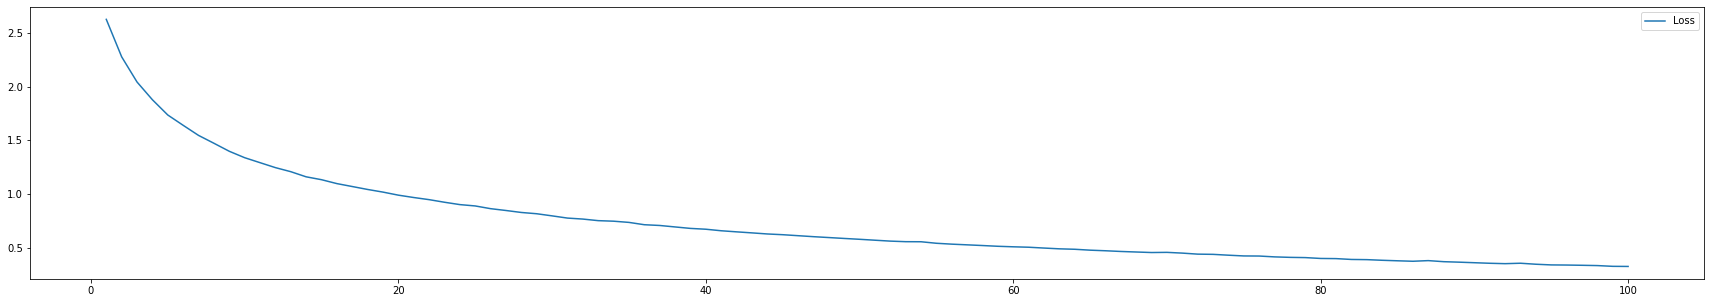

In [72]:
# print_confusion_matrix()
num_epochs = 100
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

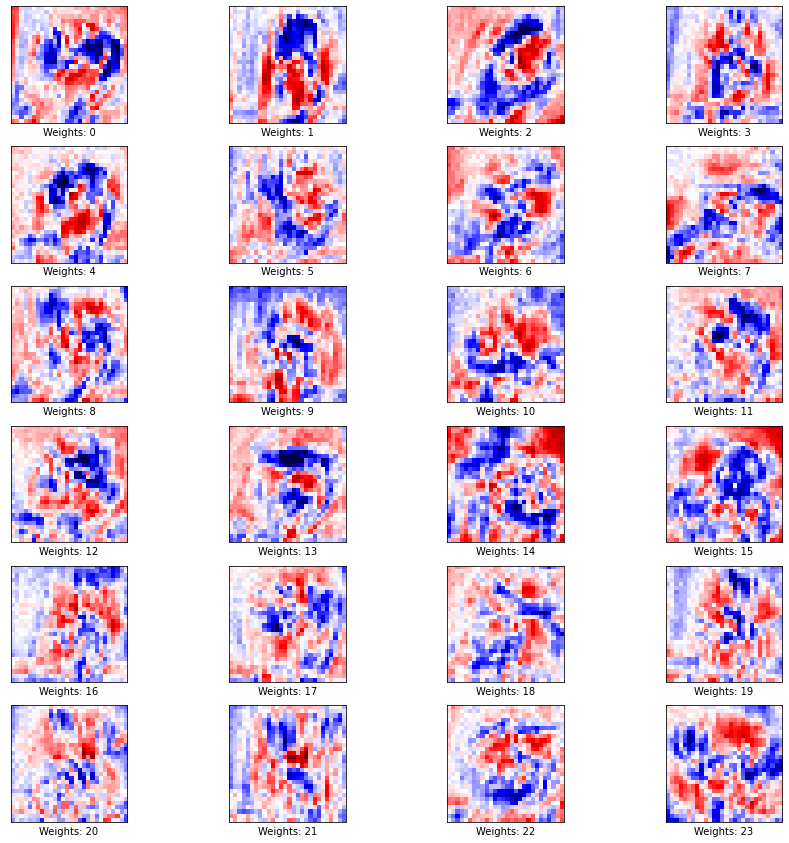

In [73]:
# plotting weights
plot_weights(weights_out)

### Report for Part b

As can be seen, model converges faster when we are using Adam Optimizer instead of the gradient descent method. ADAM is a more general and better method for minimizing loss of MLPs. It is better to use Adam for rarly epochs and the switch to SGD fo final epochs.

## Part c

### Report for Part c

As can be seen in last parts, in an MLP without hidden layer, the weight of each class will take the shape of its input. by traning more and more, the weight will mostly converge to the right shape.
Loss is plotted in each section.

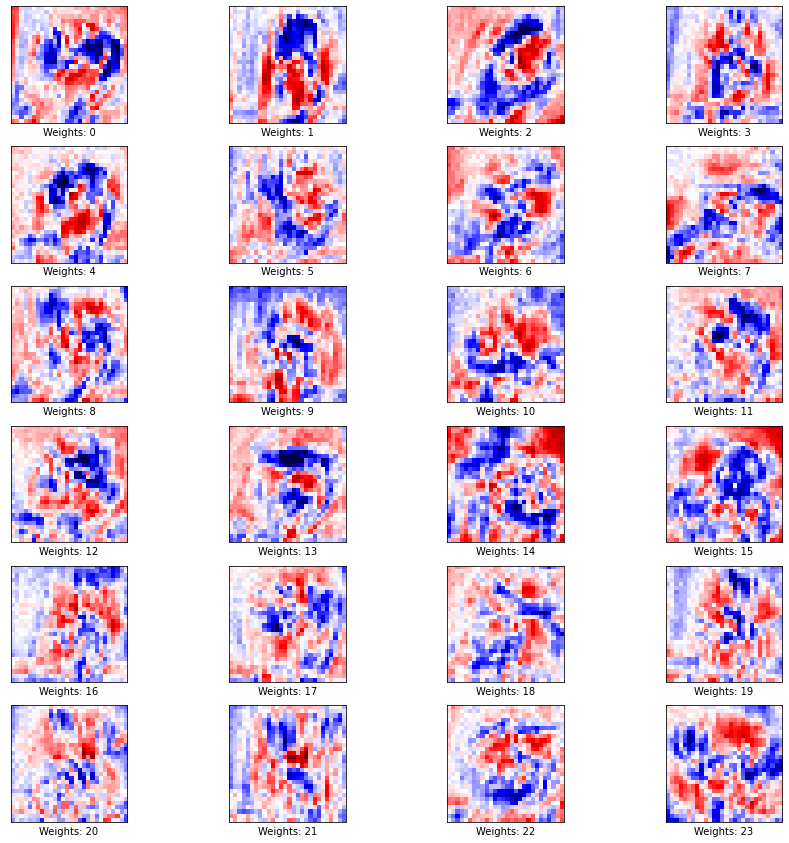

In [75]:
plot_weights(weights_out)

## Part d - Adding Dropout

#### SGD 

##### Network graph

In [ ]:
tf.reset_default_graph()

learning_rate = 0.5

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_out = tf.Variable(tf.random_normal([img_size_flat, num_classes],mean=0,stddev=1/np.sqrt(img_size_flat)))
# network biases
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)

y_pred = tf.matmul(x, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act)
y_pred_cls = tf.argmax(y_pred_act_DO, axis=1)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                   keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                   keep_prob:1}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


##### Helper Functions

In [ ]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,10)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.04 - Loss = 3.2938

 ====== Epoch 1 ====== 
Training Acc = 0.49 - Validation Acc = 0.49 - Test Acc = 0.44 - Loss = 5.0764

 ====== Epoch 11 ====== 
Training Acc = 0.84 - Validation Acc = 0.82 - Test Acc = 0.56 - Loss = 1.2117

 ====== Epoch 21 ====== 
Training Acc = 0.97 - Validation Acc = 0.97 - Test Acc = 0.68 - Loss = 0.1029

 ====== Epoch 31 ====== 
Training Acc = 1.00 - Validation Acc = 0.99 - Test Acc = 0.68 - Loss = 0.0466

 ====== Epoch 41 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.69 - Loss = 0.0291


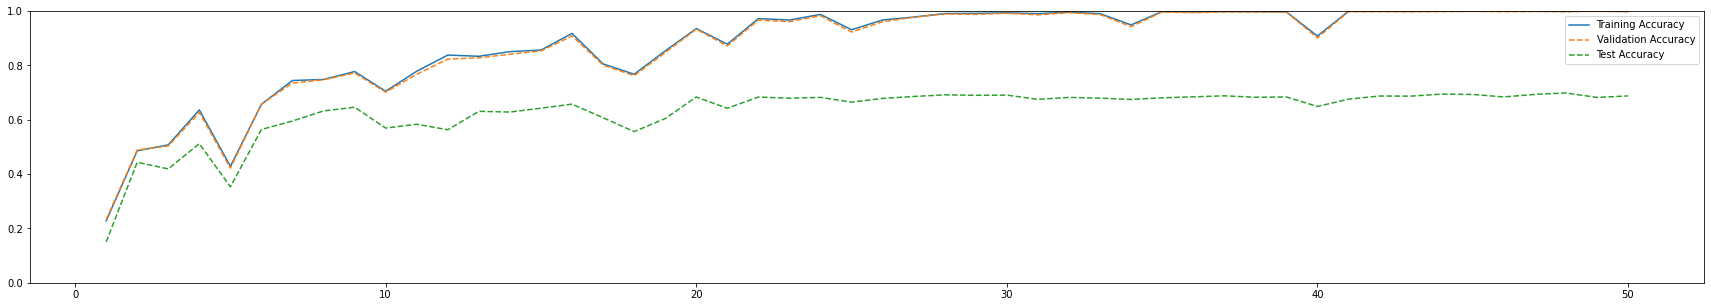

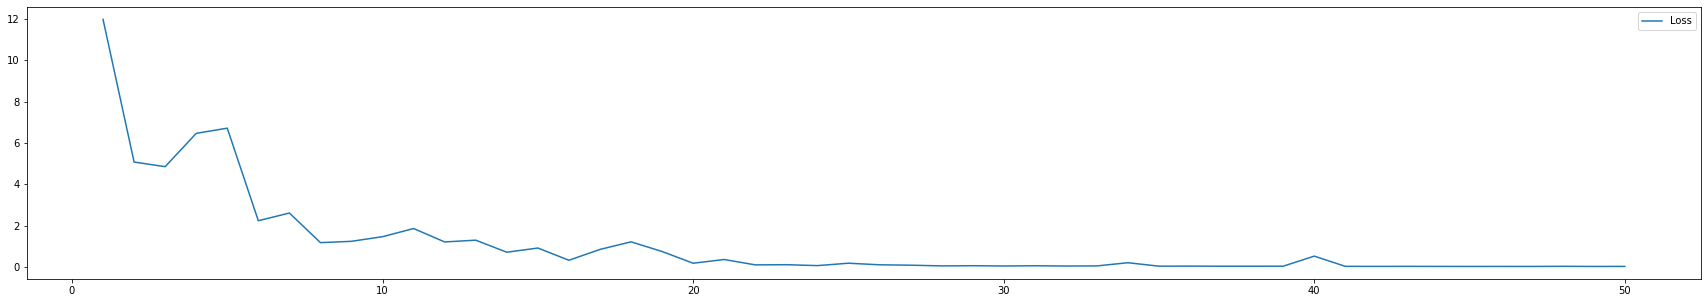

In [ ]:
# print_confusion_matrix()
num_epochs = 50
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

### Report for Part d

Adding drop out to the layers increases the speed of convergence. Aslo it can increase the accuracy on the test dataset.

Note that I have used a place holder for probability of drop out. In the training phase, this value is 0.4 and in the test phase this value is 1.

## Part e - Adding more layers

#### SGD

##### Network graph

In [ ]:
tf.reset_default_graph()

learning_rate = 0.1
batch_size = 64

hl1_n = int(2*img_size_flat)
hl2_n = int(img_size_flat)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.sigmoid(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.sigmoid(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_pred = tf.matmul(y_2_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred)
y_pred_act_DO = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_act_DO_BN = tf.compat.v1.layers.dropout(y_pred_act, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act_DO_BN, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
# loss = tf.compat.v1.losses.mean_squared_error(y_true, y_pred)
cost = tf.reduce_mean(loss)

optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate, name='SGD').minimize(cost)

# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb]}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls}


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.05 - Loss = 3.2818

 ====== Epoch 1 ====== 
Training Acc = 0.07 - Validation Acc = 0.07 - Test Acc = 0.05 - Loss = 3.0521

 ====== Epoch 11 ====== 
Training Acc = 0.59 - Validation Acc = 0.58 - Test Acc = 0.52 - Loss = 1.2243

 ====== Epoch 21 ====== 
Training Acc = 0.75 - Validation Acc = 0.74 - Test Acc = 0.61 - Loss = 0.7558

 ====== Epoch 31 ====== 
Training Acc = 0.87 - Validation Acc = 0.86 - Test Acc = 0.67 - Loss = 0.4040

 ====== Epoch 41 ====== 
Training Acc = 0.97 - Validation Acc = 0.97 - Test Acc = 0.74 - Loss = 0.1403


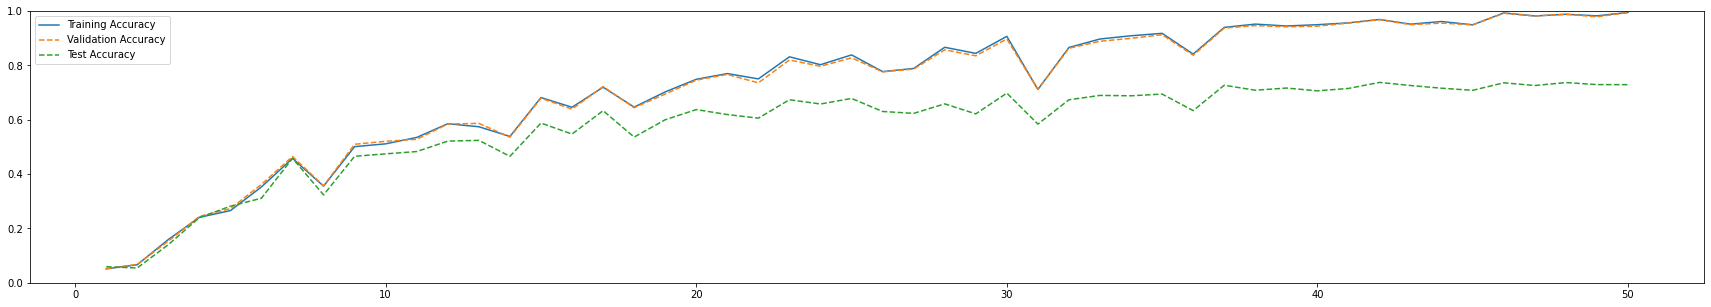

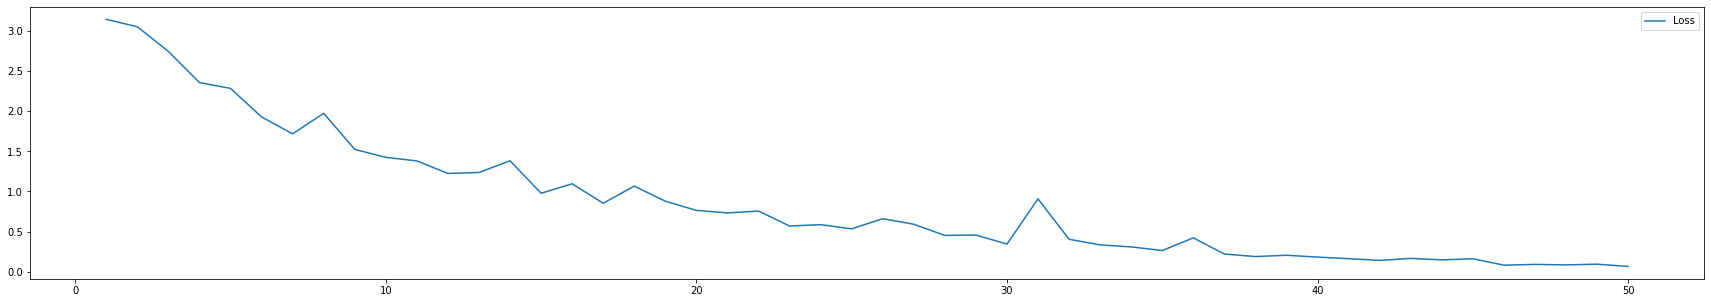

In [ ]:
# print_confusion_matrix()
num_epochs = 50
batch_size = 64
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

#### ADAM

##### Network graph

In [ ]:
tf.reset_default_graph()
beta1 = 0.9
beta2 = 0.999
learning_rate = 3e-4

hl1_n = int(512)
hl2_n = int(128)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.relu(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act, rate=keep_prob)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.relu(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act, rate=keep_prob)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_pred = tf.matmul(y_2_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                  keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                  keep_prob:1}

/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:393: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


##### Helper Functions

In [11]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,update_freq)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.04 - Test Acc = 0.03 - Loss = 3.2366

 ====== Epoch 1 ====== 
Training Acc = 0.60 - Validation Acc = 0.60 - Test Acc = 0.53 - Loss = 1.3349

 ====== Epoch 3 ====== 
Training Acc = 0.79 - Validation Acc = 0.79 - Test Acc = 0.64 - Loss = 0.7796

 ====== Epoch 5 ====== 
Training Acc = 0.80 - Validation Acc = 0.79 - Test Acc = 0.65 - Loss = 0.6280

 ====== Epoch 7 ====== 
Training Acc = 0.92 - Validation Acc = 0.91 - Test Acc = 0.72 - Loss = 0.3553

 ====== Epoch 9 ====== 
Training Acc = 0.95 - Validation Acc = 0.95 - Test Acc = 0.74 - Loss = 0.2345

 ====== Epoch 11 ====== 
Training Acc = 0.98 - Validation Acc = 0.98 - Test Acc = 0.74 - Loss = 0.1429

 ====== Epoch 13 ====== 
Training Acc = 0.98 - Validation Acc = 0.97 - Test Acc = 0.73 - Loss = 0.1199

 ====== Epoch 15 ====== 
Training Acc = 0.99 - Validation Acc = 0.99 - Test Acc = 0.74 - Loss = 0.0654

 ====== Epoch 17 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 

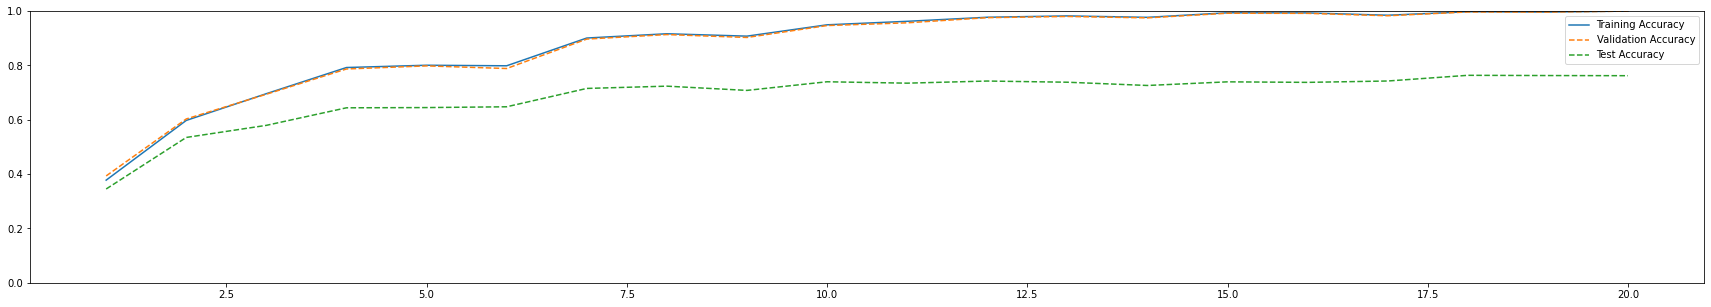

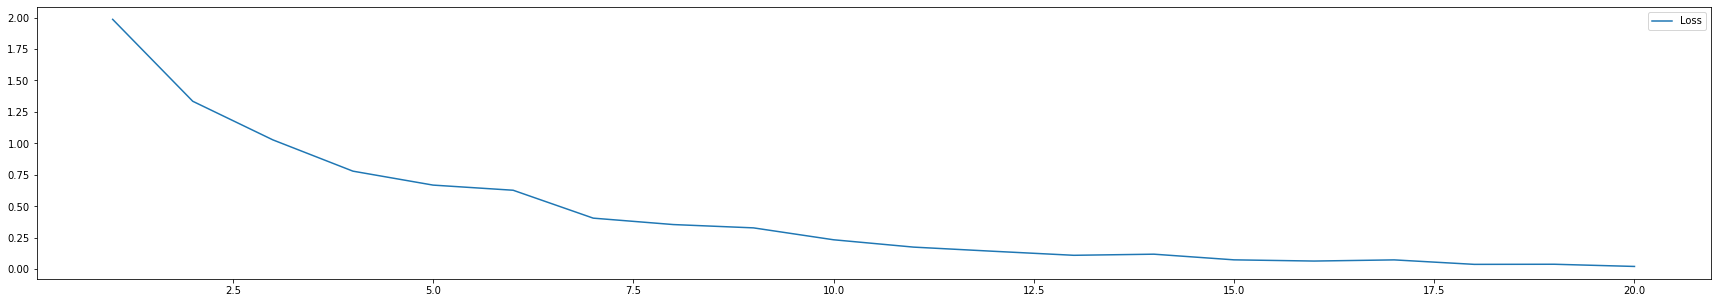

In [ ]:
# print_confusion_matrix()
num_epochs = 20
batch_size = 64
update_freq = 2
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq = update_freq)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

#### Exporting the Trained model

In [ ]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_78pAcc'

### Report for Part e

Adding more layers and batch normalization method lead to increasing the accuracy if the test dataset.

## Part f - Making the dataset balanced

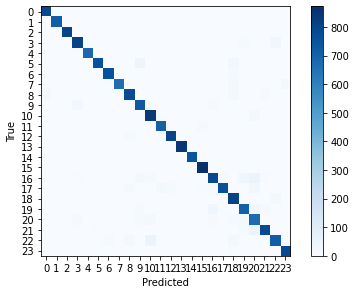

In [76]:
print_confusion_matrix()

Images with lables 10, 15, and 16 are classified perfectly. I choose Lable 16.

In [82]:
for i in range(0, 24):
  indxs = np.argwhere(y_train_cls==i)
  print("Label {0} - {1}".format(i, len(indxs)))

Label 0 - 792
Label 1 - 717
Label 2 - 801
Label 3 - 855
Label 4 - 694
Label 5 - 827
Label 6 - 765
Label 7 - 696
Label 8 - 824
Label 9 - 771
Label 10 - 858
Label 11 - 717
Label 12 - 820
Label 13 - 849
Label 14 - 751
Label 15 - 877
Label 16 - 912
Label 17 - 848
Label 18 - 828
Label 19 - 805
Label 20 - 745
Label 21 - 861
Label 22 - 813


As can be seen number of images with label 16 is more than all the othe labels. I remove 4/5 of this label in the following.

In [100]:
indxs = np.argwhere(y_train_cls==16)
indxs = [int(i) for i in indxs]
indxs = random.sample(indxs, int(4*len(indxs)/5))
print(len(x_train))
print(len(y_train_cls))
x_train_croped = np.delete(x_train, indxs, 0)
y_train_croped_cls = np.delete(y_train_cls, indxs)
print(len(x_train))
print(len(y_train_cls))
enc = OneHotEncoder()
y_train_croped = enc.fit_transform(y_train_croped_cls.reshape(-1, 1)).toarray()

19218
19218
18489
18489


##### Network graph

In [105]:
tf.reset_default_graph()
beta1 = 0.9
beta2 = 0.999
learning_rate = 3e-4

hl1_n = int(512)
hl2_n = int(128)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_out = tf.Variable(tf.random_normal([hl2_n, num_classes],mean=0,stddev=1/np.sqrt(hl2_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.relu(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act, rate=keep_prob)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.relu(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act, rate=keep_prob)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_pred = tf.matmul(y_2_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                  keep_prob:1}

feed_dict_train = {x: x_train_croped[:numb,:],
                  y_true: y_train_croped[:numb, :],
                  y_true_cls: y_train_croped_cls[:numb],
                   keep_prob:0.5}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                  keep_prob:1}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:401: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:455: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `l

##### Helper Functions

In [106]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
    for epoch in range(0,num_epochs):
        
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      if np.mod(epoch,update_freq)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)
      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 0.04 - Validation Acc = 0.03 - Test Acc = 0.04 - Loss = 3.2308

 ====== Epoch 1 ====== 
Training Acc = 0.62 - Validation Acc = 0.59 - Test Acc = 0.52 - Loss = 1.2617

 ====== Epoch 3 ====== 
Training Acc = 0.78 - Validation Acc = 0.75 - Test Acc = 0.65 - Loss = 0.7568

 ====== Epoch 5 ====== 
Training Acc = 0.84 - Validation Acc = 0.80 - Test Acc = 0.67 - Loss = 0.5484

 ====== Epoch 7 ====== 
Training Acc = 0.90 - Validation Acc = 0.87 - Test Acc = 0.71 - Loss = 0.3524

 ====== Epoch 9 ====== 
Training Acc = 0.95 - Validation Acc = 0.91 - Test Acc = 0.71 - Loss = 0.2309

 ====== Epoch 11 ====== 
Training Acc = 0.98 - Validation Acc = 0.96 - Test Acc = 0.74 - Loss = 0.1380

 ====== Epoch 13 ====== 
Training Acc = 0.99 - Validation Acc = 0.96 - Test Acc = 0.73 - Loss = 0.0947

 ====== Epoch 15 ====== 
Training Acc = 0.99 - Validation Acc = 0.98 - Test Acc = 0.73 - Loss = 0.0747

 ====== Epoch 17 ====== 
Training Acc = 0.99 - Validation Acc = 0.98 

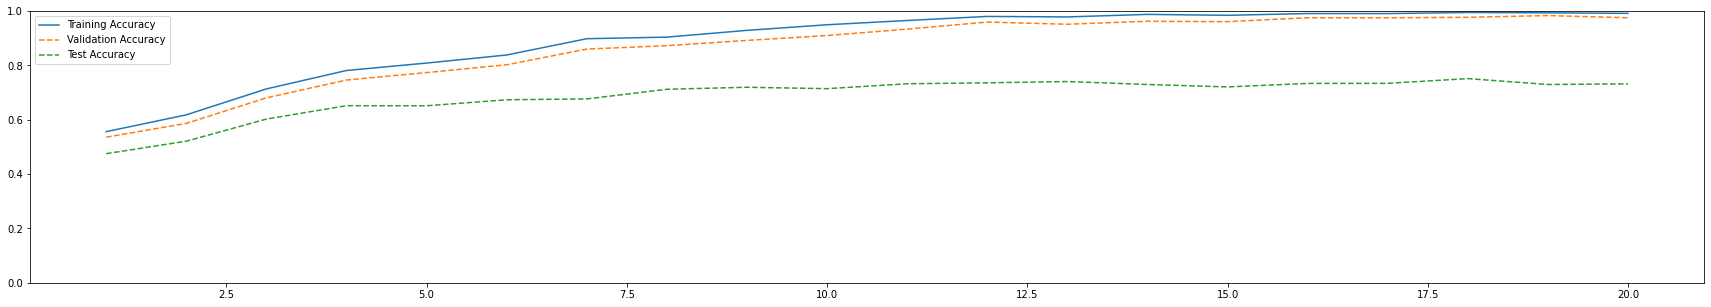

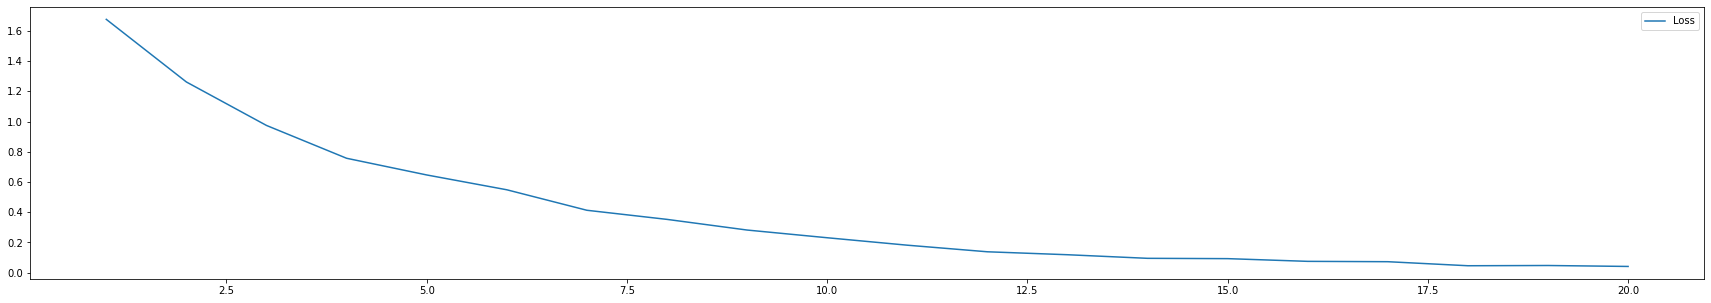

In [107]:
# print_confusion_matrix()
num_epochs = 20
batch_size = 64
update_freq = 2
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq = update_freq)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

##### Results after removing 4/5 of label 16

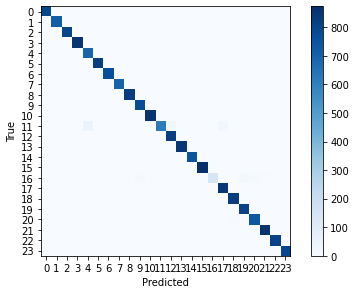

In [108]:
print_confusion_matrix()

As we expected, the new network is not biased on lable 16 and have a very low accuracy for this label.

* For making the dataset, we can remove extra images from the lables which have more images compared to the others.
* we can augment the labels which have fewer images compared to the others.

## Part g - RealTime Detection

The name of the file for real time detection is `RealTimeDetection.py`



![image 1](http://ee.sharif.edu/~amin/static/Deep/Deep_01.png)
![image 2](http://ee.sharif.edu/~amin/static/Deep/Deep_02.png)
![image 3](http://ee.sharif.edu/~amin/static/Deep/Deep_03.png)
![image 4](http://ee.sharif.edu/~amin/static/Deep/Deep_04.png)


If images are not shown for you, please take a look at https://github.com/MohammadAminAlamalhoda/sign-language-Detector Readme .

## Extra Works - Data Augmentation - Adding Rotated Images to the Training Set

I rotated some of the images in the training set by -10, -20, +10, and +20 degrees for better performance. Also, this procedure leads to a banalnced dataset.
In addition, I have put a random black square in some of the images to increase the performance of the network.

##### Augmentation of the Training Set

In [12]:
for i in range(0, 24):
  indxs = np.argwhere(y_train_cls==i)
  print("Label {0} - {1}".format(i, len(indxs)))

for j in range(0, 24):
  indxs = np.argwhere(y_train_cls==j)
  indxs = [int(w) for w in indxs]
  samples2add = 200
  indexes = random.sample(indxs, samples2add)
  for angle in [10,15]:
    for i in indexes:
      image = x_train[i,:]
      rotated_pos = rotate(np.reshape(image, img_shape), angle=angle, reshape=False)
      x1 = random.randrange(5,23)
      y1 = random.randrange(5,23)
      rotated_pos[x1:x1+4, y1:y1+4] = 0

      rotated_neg = rotate(np.reshape(image, img_shape), angle=-1*angle, reshape=False)
      x1 = random.randrange(5,23)
      y1 = random.randrange(5,23)
      rotated_neg[x1:x1+4, y1:y1+4] = 0

      rotated_pos = np.reshape(rotated_pos, (1,img_size_flat))
      rotated_neg = np.reshape(rotated_neg, (1,img_size_flat))

      x_train = np.append(x_train, rotated_pos, axis=0)
      x_train = np.append(x_train, rotated_neg, axis=0)
      y_train_cls = np.append(y_train_cls, y_train_cls[i])
      y_train_cls = np.append(y_train_cls, y_train_cls[i])

    if len(np.argwhere(y_train_cls==j)) >= 1500:
      break

for i in range(0, 24):
  indxs = np.argwhere(y_train_cls==i)
  print("Label {0} - {1}".format(i, len(indxs)))

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1)).toarray()

Label 0 - 792
Label 1 - 717
Label 2 - 801
Label 3 - 855
Label 4 - 694
Label 5 - 827
Label 6 - 765
Label 7 - 696
Label 8 - 824
Label 9 - 771
Label 10 - 858
Label 11 - 717
Label 12 - 820
Label 13 - 849
Label 14 - 751
Label 15 - 877
Label 16 - 912
Label 17 - 848
Label 18 - 828
Label 19 - 805
Label 20 - 745
Label 21 - 861
Label 22 - 813
Label 23 - 792
Label 0 - 1592
Label 1 - 1517
Label 2 - 1601
Label 3 - 1655
Label 4 - 1494
Label 5 - 1627
Label 6 - 1565
Label 7 - 1496
Label 8 - 1624
Label 9 - 1571
Label 10 - 1658
Label 11 - 1517
Label 12 - 1620
Label 13 - 1649
Label 14 - 1551
Label 15 - 1677
Label 16 - 1712
Label 17 - 1648
Label 18 - 1628
Label 19 - 1605
Label 20 - 1545
Label 21 - 1661
Label 22 - 1613
Label 23 - 1592


##### Network graph

In [13]:
tf.reset_default_graph()
beta1 = 0.9
beta2 = 0.999
learning_rate = 1e-4

hl1_n = int(2*784)
hl2_n = int(784)
hl3_n = int(256)

# input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='X_INPUT')
# output
y_true = tf.placeholder(tf.float32, [None, num_classes], name='Y_OUT_TRUE')
# output class
y_true_cls = tf.placeholder(tf.int64, [None], name='Y_OUT_TRUE_CLASS')

# network weights
weights_1 = tf.Variable(tf.random_normal([img_size_flat, hl1_n],mean=0,stddev=1/np.sqrt(img_size_flat)))
weights_2 = tf.Variable(tf.random_normal([hl1_n, hl2_n],mean=0,stddev=1/np.sqrt(hl1_n)))
weights_3 = tf.Variable(tf.random_normal([hl2_n, hl3_n],mean=0,stddev=1/np.sqrt(hl2_n)))
weights_out = tf.Variable(tf.random_normal([hl3_n, num_classes],mean=0,stddev=1/np.sqrt(hl3_n)))
# network biases
biases_1 = tf.Variable(tf.random_normal([hl1_n],mean=0,stddev=1/np.sqrt(hl1_n)))
biases_2 = tf.Variable(tf.random_normal([hl2_n],mean=0,stddev=1/np.sqrt(hl2_n)))
biases_3 = tf.Variable(tf.random_normal([hl3_n],mean=0,stddev=1/np.sqrt(hl3_n)))
biases_out = tf.Variable(tf.random_normal([num_classes],mean=0,stddev=1/np.sqrt(num_classes)))

keep_prob = tf.placeholder(tf.float32)


y_1 = tf.matmul(x, weights_1) + biases_1
y_1_act = tf.nn.relu(y_1)
y_1_act_DO = tf.compat.v1.layers.dropout(y_1_act, rate=keep_prob)
y_1_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_1_act_DO)

y_2 = tf.matmul(y_1_act_DO_BN, weights_2) + biases_2
y_2_act = tf.nn.relu(y_2)
y_2_act_DO = tf.compat.v1.layers.dropout(y_2_act, rate=keep_prob)
y_2_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_2_act_DO)

y_3 = tf.matmul(y_2_act_DO_BN, weights_3) + biases_3
y_3_act = tf.nn.relu(y_3)
y_3_act_DO = tf.compat.v1.layers.dropout(y_3_act, rate=keep_prob)
y_3_act_DO_BN = tf.compat.v1.layers.batch_normalization(y_3_act_DO)

y_pred = tf.matmul(y_3_act_DO_BN, weights_out) + biases_out
y_pred_act = tf.nn.softmax(y_pred, name="Y_PRED")
y_pred_cls = tf.argmax(y_pred_act, axis=1, name="Y_PRED_CLS")

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=1e-08, name='ADAM').minimize(cost)
# correct prediction
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# accuracy of the network
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# running the network
session = tf.Session()
session.run(tf.global_variables_initializer())

numb = -1
feed_dict_test = {x: x_test[:numb,:],
                  y_true: y_test[:numb, :],
                  y_true_cls: y_test_cls[:numb],
                  keep_prob:1}

feed_dict_train = {x: x_train[:numb,:],
                  y_true: y_train[:numb, :],
                  y_true_cls: y_train_cls[:numb],
                   keep_prob:0.4}

feed_dict_validation = {x: x_validation,
                  y_true: y_validation,
                  y_true_cls: y_validation_cls,
                  keep_prob:1}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:401: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:455: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `l

##### Helper Functions

In [14]:
def optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq):
    accs_train = np.zeros([num_epochs])
    accs_validation = np.zeros([num_epochs])
    accs_test = np.zeros([num_epochs])
    loss = np.zeros([num_epochs])
    x_train = feed_dict_train[x]
    y_train = feed_dict_train[y_true]
    [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
    [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
    [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
    
    print('\n ====== Epoch 0 ====== ')
    print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)

    summary_writer = tf.summary.FileWriter('/content/drive/My Drive/Courses/DeepLearning/HW01/graphs', tf.get_default_graph())

    for epoch in range(0,num_epochs):
      list_of_samples = [i for i in range(0, x_train.shape[0])]
      for i in range(int(x_train.shape[0]/batch_size)):
          if len(list_of_samples) < batch_size:
            list_of_samples = [i for i in range(0, x_train.shape[0])]
          indexes = random.sample(list_of_samples, batch_size)
          for j in indexes:
            list_of_samples.remove(j)
          x_batch = x_train[indexes, :]
          y_true_batch = y_train[indexes]
          feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob:feed_dict_train[keep_prob]}
          session.run(optimizer, feed_dict=feed_dict)
      Test_Acc = session.run(accuracy, feed_dict=feed_dict_test)
      summary_str = tf.Summary(value=[tf.Summary.Value(tag="accuracy", simple_value=Test_Acc)])
      summary_writer.add_summary(summary_str, epoch)

      if np.mod(epoch,update_freq)==1:
        print('\n ====== Epoch {0} ====== '.format(epoch))
        [Test_Accuracy, _] = calcAccuracy(feed_dict_test)
        [Train_Accuracy, Loss] = calcAccuracy(feed_dict_train)
        [Valid_Accuracy, _] = calcAccuracy(feed_dict_validation)
        print("Training Acc = {0:.2f} - Validation Acc = {1:.2f} - Test Acc = {2:.2f} - Loss = {3:.4f}\n".format(Train_Accuracy, Valid_Accuracy, Test_Accuracy, Loss) , sep=' ', end='', flush=False)

      [accs_train[epoch], loss[epoch]]= calcAccuracy(feed_dict_train)
      [accs_validation[epoch], _]= calcAccuracy(feed_dict_validation)
      [accs_test[epoch], _] = calcAccuracy(feed_dict_test)
    summary_writer.close()
    return accs_train, accs_validation, accs_test, loss

##### Runing Optimization


 ====== Epoch 0 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.84 - Loss = 0.0120

 ====== Epoch 1 ====== 
Training Acc = 0.96 - Validation Acc = 0.97 - Test Acc = 0.77 - Loss = 0.1132

 ====== Epoch 3 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.86 - Loss = 0.0163

 ====== Epoch 5 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.87 - Loss = 0.0059

 ====== Epoch 7 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.87 - Loss = 0.0042

 ====== Epoch 9 ====== 
Training Acc = 0.99 - Validation Acc = 1.00 - Test Acc = 0.84 - Loss = 0.0236

 ====== Epoch 11 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 - Test Acc = 0.87 - Loss = 0.0051

 ====== Epoch 13 ====== 
Training Acc = 0.99 - Validation Acc = 1.00 - Test Acc = 0.84 - Loss = 0.0203

 ====== Epoch 15 ====== 
Training Acc = 0.99 - Validation Acc = 1.00 - Test Acc = 0.84 - Loss = 0.0285

 ====== Epoch 17 ====== 
Training Acc = 1.00 - Validation Acc = 1.00 

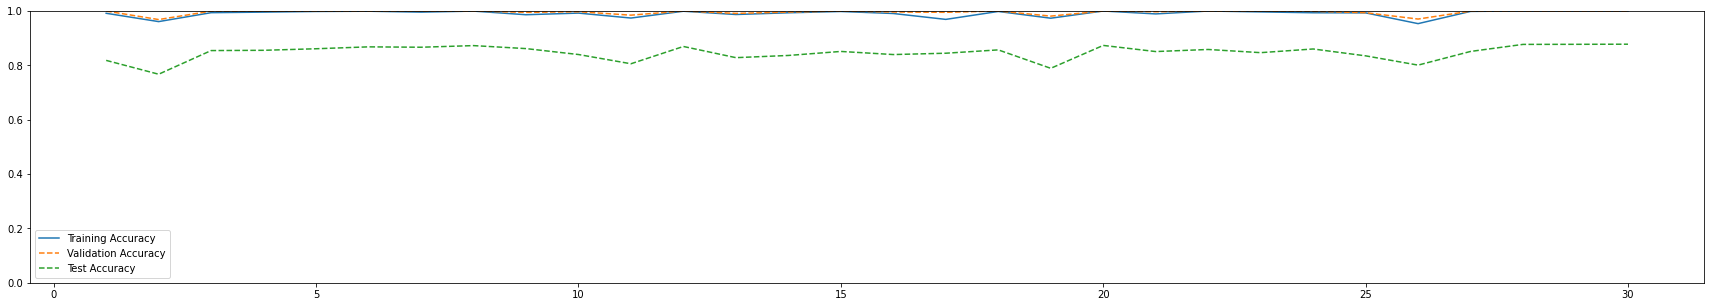

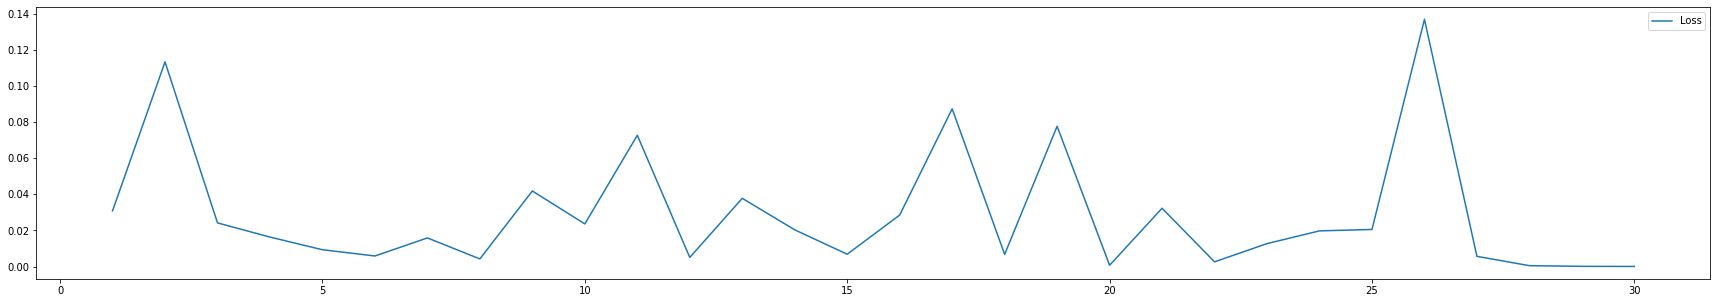

In [16]:
# print_confusion_matrix()
num_epochs = 30
batch_size = 32
update_freq = 2
[accs_train, accs_validation, accs_test, loss] = optimize(num_epochs, batch_size, feed_dict_train, feed_dict_validation, update_freq = update_freq)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_train, label='Training Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_validation, '--', label='Validation Accuracy')
plt.plot(np.linspace(1, num_epochs, num_epochs), accs_test, '--', label='Test Accuracy')
plt.ylim([0,1])
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(30,5))
plt.plot(np.linspace(1, num_epochs, num_epochs), loss, label='Loss')
plt.legend()
plt.show()

# print_confusion_matrix()

In [56]:
[Test_Accuracy, _] = calcAccuracy(feed_dict_test)
print(Test_Accuracy)

0.88132757


#### Exporting the model

In [58]:
saver = tf.train.Saver()
saver.save(session, '/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_89pAcc')

'/content/drive/My Drive/Courses/DeepLearning/Sign_Detector_89pAcc'

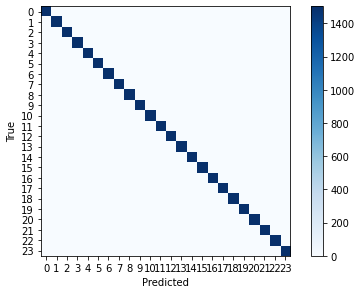

In [57]:
print_confusion_matrix()